Look at object detection rate weighed by topic

In [2]:
from src.features.videos.objects import object as object_helper
from src.models.lda import lda as lda_helper
from src import constants

import pandas as pd
import numpy as np

import psycopg2

%load_ext autoreload
%autoreload 2

/Users/claasmeiners/.virtualenvs/video_article_retrieval/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
# Get the detected objects and the topics
object_occurence_rate = object_helper.divide_by_duration(object_helper.get_occurence_sum())
object_occurence_rate.head()
features_connection = psycopg2.connect(database="video_article_retrieval", user="postgres")
average_topics = pd.read_sql("SELECT * FROM average_topics", con=features_connection)

In [6]:
# Merge average topics and detected objects
data = pd.merge(average_topics, object_occurence_rate,  how='right', left_on=['id','platform'], right_on = ['id','platform'])
data.head()

,id,platform,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,sink,refrigerator,book,clock,vase,scissors,teddy_bear,hair_drier,toothbrush,duration
0,fox26houston/10157181811750348,facebook,0.0,0.767010,0.0,0.153838,0.046777,0.000000,0.005562,0.020166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449536
1,jessica.salazar.338/2111423425558048,facebook,0.0,0.099226,0.0,0.158874,0.159987,0.016518,0.000000,0.020300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82047
2,JoyNewsOnTV/2167529583318936,facebook,0.0,0.000000,0.0,0.000000,0.304423,0.000000,0.675539,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196371
3,100009629315589/737936519870652,facebook,0.0,0.546476,0.0,0.000000,0.138599,0.000000,0.000000,0.201420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218823
4,185998671553/10157087493556554,facebook,0.0,0.000000,0.0,0.264172,0.359579,0.117422,0.000000,0.255583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38380


In [52]:
from collections import defaultdict
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format

topic_objects = defaultdict(lambda: defaultdict(int))

topics = lda_helper.get_topic_columns(10)
objects = [label.replace(" ", "_") for label in constants.COCO_CLASS_NAMES]

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

for label in objects:
    for topic in topics:
        topic_objects[label][topic] = sum(data[label] * data[topic])

df = pd.DataFrame(topic_objects)
df = df.apply(lambda x: x/x.max(), axis=0)

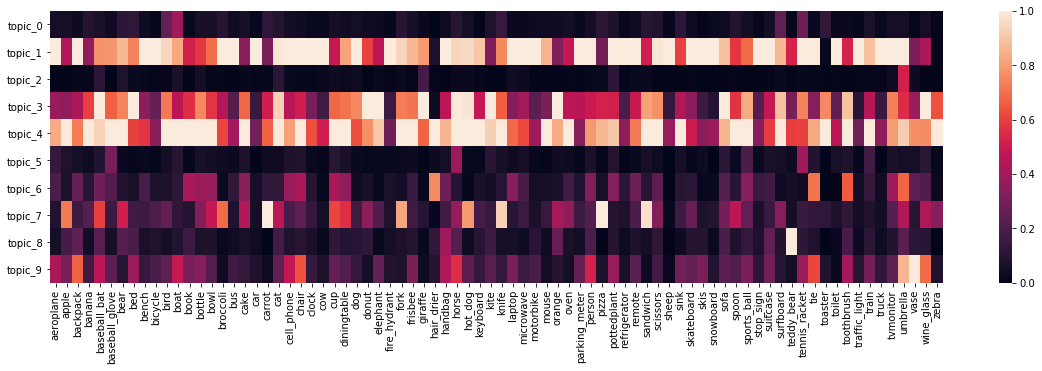

In [57]:
import seaborn
from matplotlib import pyplot


fig, ax = pyplot.subplots(figsize=(20,5))
seaborn.heatmap(ax=ax, data=df)
pyplot.savefig("topic_objects_heatmap.pdf")